# Introduction to XIA Workflows and Expected Gradients.
*Developed by Simon Topp, Jeremy Diaz, and Lauren Koenig*

Explainable AI (XAI) is a rapidly growing aspect of the ML field that specifically focuses on increasing the transparency and interpretability of otherwise “black-box” modelling approaches.  When done effectively, XAI improves trust in model predictions, assists in understanding causality within complex architectures, enhances our ability to diagnose and refine models, and improves transferability/robustness of models when moving to new domains.

This notebook walks through a simple example of using permutation based feature importance and Expected Gradients to better understand how a LSTM model is making stream temperature predictions across time. *If you re-run/edit/explore/play with the code in the walkthrough (and you should!), be sure to run each cell sequentially to avoid errors*

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

#### First, lets load in some data

1) Click this [link](https://github.com/SimonTopp/xai-workflows/blob/main/test_data/DRB_2019.npz?raw=true) to download our example data.  It's comprised of water year 2019 drivers and temperature observations for 455 river segments in the Delaware River Basin.

2) Once you've downloaded the file, run the cell below, click choose file, and select the downloaded file named `DRB_2019.npz`. (*You need third party cookies enabled)

In [ ]:
uploaded = files.upload()

Saving DRB_2019.npz to DRB_2019.npz


In [ ]:
prepped = np.load('/content/DRB_2019.npz')
x_vars = prepped['x_vars']
x = prepped['x_trn']
y = prepped['y_trn']
dates = prepped['dates']

prepped.files, x.shape, x_vars

(['x_trn', 'y_trn', 'sed_ids', 'dates', 'x_vars', 'y_mean', 'y_std'],
 (455, 365, 7),
 array(['Slope', 'Elevation', 'Width', 'Air Temp', 'SW Rad.', 'Precip',
        'Potent. ET.'], dtype='<U11'))

We can see from the shape of our data that it's comprised of 7 drivers and covers 455 river segments over 365 days. (shape -> `[n reaches, n days, n features]`).  Throughout this notebook, we'll use the reach with the most observations as an illustrative example. Running the cell below will show you the observed stream temperature for our illustratiion reach.

Text(0, 0.5, 'Normalized Stream Temp')

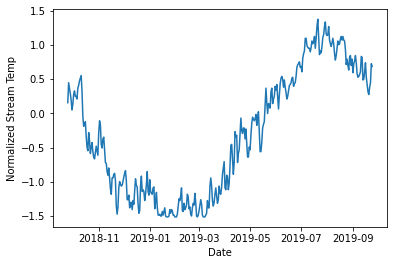

In [ ]:
target_seg = np.count_nonzero(~np.isnan(prepped['y_trn'].reshape(455,365)),axis=1).argmax()
plt.plot(dates,y[target_seg])
plt.xlabel('Date')
plt.ylabel('Normalized Stream Temp')

#### Define our model and loss function

Here we'll use a simple LSTM for sequence to sequence predictions.  Since our observations have missing values, we'll also define a custom loss function that masks those missing values prior to calculating the loss.

In [ ]:
# Simple LSTM made from scratch
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        # See the file "neuralnet_math_README.md" in the root directory for
        # equations and implementation details
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        
        self.dense = nn.Linear(hidden_dim, 1)
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                    torch.zeros(bs, self.hidden_size).to(x.device))
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        out = self.dense(hidden_seq)
        return out

def rmse_masked(y_pred, y_true):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

Training over 100 epochs shows that the model learns to predict the temperature in our target river reach pretty well!

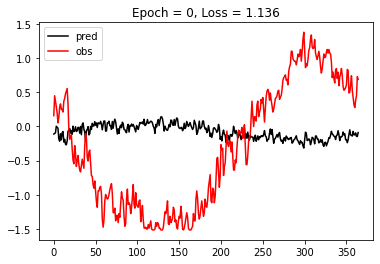

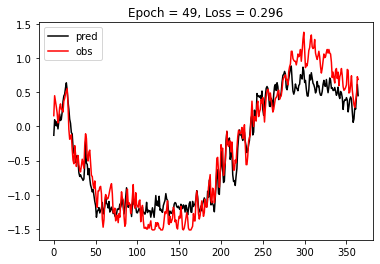

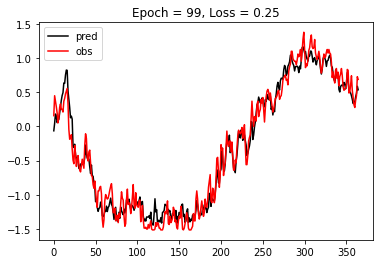

In [ ]:
device = 'cpu'
model = LSTM(7,10,recur_dropout=.3).to(device)
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

for i in range(100):
    out = model(x)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 50 == 0 or i == 0:
        plt.plot(out[target_seg].detach(), color = 'black', label = 'pred')
        plt.plot(y[target_seg], color = 'red', label = 'obs')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.show()
        plt.pause(0.001)

## Lets get a sense for how the model works by conducting some simple permutation based attribution exercises

First, we'll calculate permuatation based feature importance. The idea behind permutation based feature importance is very intuitive. It involves iterating through your drivers, swapping the real values with noise, and then calcating the change in model error between predictions with the noised and un-noised data.

In [ ]:
def calc_permutation_feature_importance(model, data_in, scale_std):
    original_y_hat = model(data_in).detach()
    rmse_original = rmse_masked(original_y_hat,y)
    fi_ls=[]
    for var in range(len(x_vars)):
        x_hypothesis = data_in.detach().clone()
        var_range = torch.quantile(x_hypothesis[:,:,var].flatten(),torch.tensor([.1,.9]))
        #Make random distribution within the range of the target variable
        x_hypothesis[:, :, var] = (var_range[0]-var_range[1])*torch.rand_like(x_hypothesis[:, :, var])+var_range[1]
        y_hypothesis = model(x_hypothesis).detach()
        rmse_hypothesis = rmse_masked(y_hypothesis,y)
        delta_rmse = rmse_hypothesis-rmse_original
        fi_ls.append(delta_rmse)
    return np.array(fi_ls)

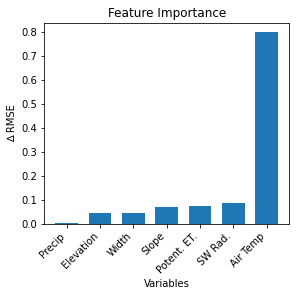

In [ ]:
feat_imp = calc_permutation_feature_importance(model, x, prepped['y_std'])
ordered_importance_of_vars = np.argsort(feat_imp)

### Plot up the results in order of importance
plt.figure(figsize=(4,4),constrained_layout=True) 
plt.bar(np.linspace(0,len(feat_imp),len(feat_imp)),feat_imp[ordered_importance_of_vars])
plt.xticks(np.linspace(0,len(feat_imp),len(feat_imp)), labels = x_vars[ordered_importance_of_vars], rotation = 45,ha='right')
plt.title('Feature Importance')
plt.ylabel('∆ RMSE')
plt.xlabel("Variables");

Right away this exercise tells us that the model is largely driven by air temperature. While this example focuses on a global concept of model function, we can apply the same ideas across time (or space) to gain insight on *when and where* features are important in addition to just what features are important.

Below, we'll apply the same ideas, but through time.  Specifically, we'll noise a random period in the middle of our dataset and measure how predictions change between the noised and un-noised data.

In [ ]:
x_norm = x[1].unsqueeze(dim=0)
x_noised=torch.rand_like(x_norm)
x_noised[:,:50,:] = x_norm[:,:50,:]
x_noised[:,100:,:] = x_norm[:,100:,:]

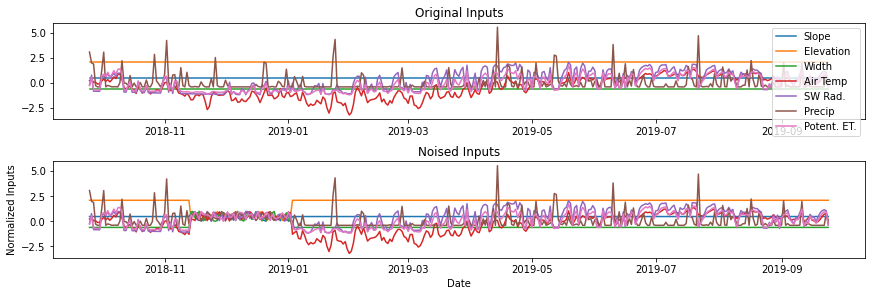

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,4), constrained_layout =True)
ax[0].set_title('Original Inputs')
ax[1].set_title('Noised Inputs')
for i in range(len(x_vars)):
    ax[0].plot(dates,x_norm[:,:,i].flatten(),label=x_vars[i])
    ax[1].plot(dates,x_noised[:,:,i].flatten())
    ax[0].legend()
    plt.xlabel('Date')
    plt.ylabel('Normalized Inputs')

Text(0, 0.5, 'Prediction\nDifference')

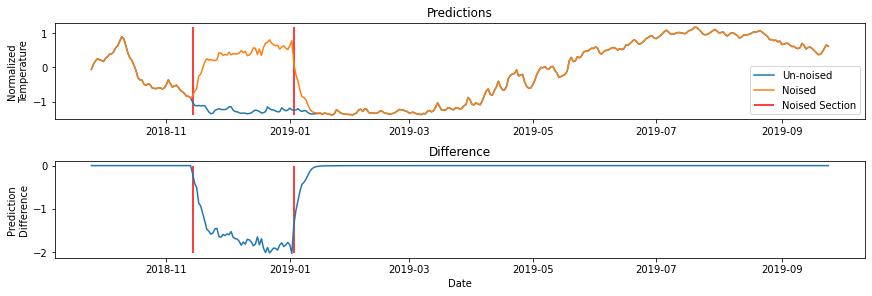

In [ ]:
model.eval()
preds_norm = model(x_norm).detach().flatten()
preds_noised = model(x_noised).detach().flatten()
difference = preds_norm-preds_noised

fig, ax = plt.subplots(2,1,figsize=(12,4),constrained_layout=True)
ax[0].plot(dates,preds_norm,label='Un-noised')
ax[0].plot(dates,preds_noised,label='Noised')
ax[0].vlines(x=dates[[50,100]],ymin=min(preds_norm),ymax=max(preds_norm),color='red', label='Noised Section')
ax[0].legend()
ax[0].set_title('Predictions')
ax[0].set_ylabel('Normalized\nTemperature')
ax[1].plot(dates, difference)
ax[1].set_title('Difference')
ax[1].vlines(x=dates[[50,100]],ymin=min(difference),ymax=max(difference),color='red', label='Noised Section')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Prediction\nDifference')

Using a simple permutation experiment we can see that the model's memory is relatively short.  While an LSTM can theoretically learn long term relationships in the data, we see here that the noised predictions (orange) begin to match the original (blue) within ~15 days of moving noised inputs back to the original inputs.

## What can a more robust method like Expected Gradients tell us?

While the permuation based experiments are great for their simplicity and intuitiveness, they also are coarse in the information they can provide.  They don't account for feature interactions, don't address the direction of feature attribution, are inherently linked to model error, and can lead to unrealistic prediction situations.  For example, we'd never expect a situation with super high temperatures in the middle of winter, but random permutations could lead to that (see Christoph Molnar [Interpretable ML](https://christophm.github.io/interpretable-ml-book/feature-importance.html) for a good discussion).

[Expected Gradients](https://www.nature.com/articles/s42256-021-00343-w) -and their predecessor [Integrated Gradients](https://arxiv.org/abs/1703.01365)- are generally considered a more robust approach to feature attribution. Both methods work by measuring the change in prediction as input features move from a "baseline" state to the observed state we're trying to interpret.  For Integrated Gradients, the user needs to define what the baseline is. Expected Gradients generates the baseline by taking repeated random samples from the training or testing data. Attribution calculations are are tied directly to the gradients of the model, and because they create baselines by sampling real inputs, you never start from an unrealistic prediction situation.  The robustness of the two methods revolves around their:

- Sensitivity – For every input and baseline that differ in one feature and have different predictions then the differing feature should be given non-zero attribution. Similarly, if the model does not mathematically depend on a variable, then it’s attribution should be zero. 

- Implementation invariance – The attributions are always identical for models that produce the exact same results via different implementations or architectures. 

- Completeness - The feature attributions always add up to the difference between the output of your given input and the baseline input.   

In [ ]:
def expected_gradients_lstm(x, x_set, model, n_samples, temporal_focus=None):

    n_series = x_set.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]
    
    for k in range(n_samples):
        # SAMPLE A SERIES FROM OUR DATA
        rand_seq = np.random.choice(n_series) # rand_time may be more accurate
        baseline_x = x_set[rand_seq].to(device)

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        else:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:,temporal_focus, :]))

        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/n_samples
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/n_samples)

    return(expected_gradients.detach().cpu().numpy())

First, we'll calculate the Expected Gradients with regards to all the predictions in our illustration reach. What this means is that we're looking at the change in input values compared to the change in the predicted values across *all* the timesteps as we move from a baseline state to our target state. Further down, we'll look at the change in inputs compared to the change in prediction at a *single* time step.

In [ ]:
## Define our target reach
x_target = x[target_seg].unsqueeze(dim=0)
## Calculate Expected Gradients Using 100 random baselines (in practice ~200 samples is preferred)
EGs_overall = expected_gradients_lstm(x_target,x,model,100)

When plotted together, we can get a sense of the relative magnitude of attribution assigned to each input feature.  The absolute magnitude of an input at a given timestep is indicative of it's importance for predictions throughout the series.

Text(0, 0.5, 'Expected Gradient')

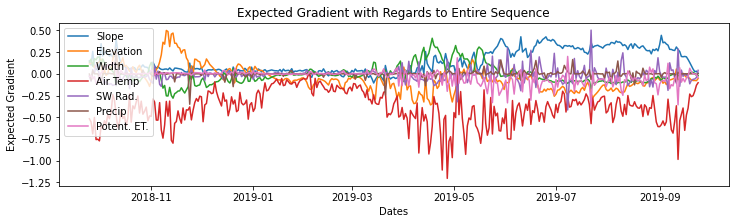

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
ax.set_title("Expected Gradient with Regards to Entire Sequence")
for i in range(len(x_vars)):
    ax.plot(dates, EGs_overall[0, :, i], label = x_vars[i])
ax.legend(loc = 'upper left')
ax.set_xlabel('Dates')
ax.set_ylabel('Expected Gradient')


When plotted individually below, we can start to see the nuance in how the model is making predictions. Remember, the absolute magnitude of the expected gradient is a measure of that inputs importance.  For example:
- Static variables (Slope, Elevation, and Width) all show fairly minimal attribution during the winter when flows are low and it's consistently cold. During the shoulder seasons when there is more variation in domain conditions across the catchment, these static variables become more important.
- Temperature consistently has high attribution.
- Precipitation show's episodic attribution associated with distinct events.
- Evapotranspiration shows almost no attribution during the winter when vegetation is relatively dormant, but begins to have an influence in spring around when we'd expect leaf out.

As you can see, the level of detail we're able to capture in terms of interogating the model with Expected Gradients is much higher than that of the permuatation based experiments.

Text(0, 0.5, 'Expected Gradients')

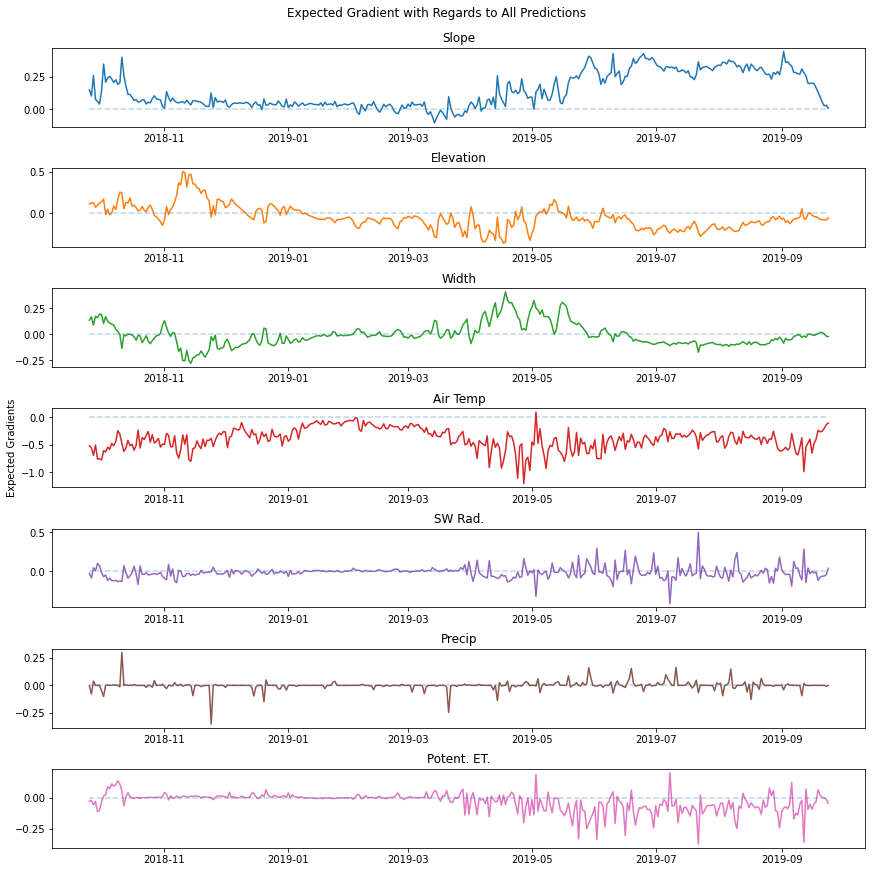

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(7,1,figsize=(12,12),constrained_layout=True)
fig.suptitle("Expected Gradient with Regards to All Predictions")
for i in range(len(x_vars)):
    ax[i].plot(dates,EGs_overall[0, :, i], label = x_vars[i], color = colors[i])
    ax[i].set_title(x_vars[i])
    ax[i].plot(dates,np.repeat(0,len(dates)),'--',alpha=.3)
ax[3].set_ylabel('Expected Gradients')

## Different XAI approaches can be complementary

One additional benefit of Expected Gradients is that it can target either an individual prediction or a set of prediction.  Above we looked at the expected gradients with regards to predictions across all timesteps, but we can use a targeted prediction to better understand a specific subset of our dataset.  We can also use more targeted predictions to validate the results we got from the permutation based experiments.

Think back to 5 minutes ago when we said that our model's memory doesn't extend back much more than 15-20 days?  We can double check that result with Expected Gradients. Here, we'll just inspect the feature attribution for the last day in the sequence.

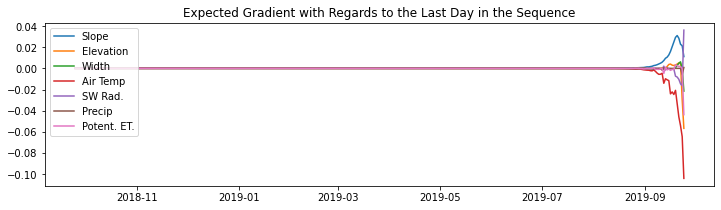

In [ ]:
EGs_targeted = expected_gradients_lstm(x_target,x,model,100,temporal_focus=-1)
fig, ax = plt.subplots(figsize=(12,3))
ax.set_title("Expected Gradient with Regards to the Last Day in the Sequence")
for i in range(len(x_vars)):
    ax.plot(dates, EGs_targeted[0, :, i], label = x_vars[i])
ax.legend(loc = 'upper left')

Above we see similar results to those of the the permutation based experiments. Specifically, that the relative memory of the model is fairly short.  Other than temperature, almost no feature has any influence on the last prediction in the sequence beyond the ~20 days prior. The power of expected gradients is that we can do this same thing across many situations. For example, trying to how a streamflow model predicts peak discharge, how model memory changes over seasons (e.g. the influence of snowpack), and any other creative application you can come up with.

## Additional resources and thoughts

Hopefully the above example highlights the ability of relatively simple XAI methods to significantly improve our understanding of an otherwise opaque machine learning model.  However, keep in mind that the examples here are meant to be lightweight, intuitive, and easily accessible. For real applications, XAI methods should be applied to fully trained models, and in many cases on the testing data rather than training. 

Here we use custom functions to increase the transparancy of what's happening, but there are also many existing libraries that can apply these methods and more -i.e. [Captum](https://github.com/pytorch/captum) and [Shap](https://github.com/slundberg/shap)-. In our personal experience, these existing libraries are great for low-dimensional models, but become less well suited to spatially and temporally aware architectures.  The example here focuses on temporal attribution, but similar approaches can be used to interogate spatial relationships for models that can learn spatial depencies (i.e. graph networks).  It's also important to keep in mind that all XAI approaches have their strengths and weaknesses, and that it's important to understand those strengths and weakneses when interpreting any results. For more examples applying similar workflows but with additional methods and different model architectures, visit the [USGS XAI github repository](https://github.com/USGS-R/xai-workflows).


![xkcd](https://imgs.xkcd.com/comics/machine_learning_2x.png)